# PIP

In [1]:
!pip install tensorflow==2.12.0 keras 2.12.0

ERROR: Could not find a version that satisfies the requirement 2.12.0 (from versions: none)
ERROR: No matching distribution found for 2.12.0


In [9]:
!pip install opendatasets --upgrade
!pip install recommenders

  Using cached recommenders-1.2.0-py3-none-any.whl.metadata (13 kB)
  Using cached category_encoders-2.6.4-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached cornac-1.18.0-cp311-cp311-win_amd64.whl.metadata (23 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached lightfm-1.17.tar.gz (316 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached lightgbm-4.5.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached locust-2.32.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached numba-0.60.0-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Gettin

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [25 lines of output]
      Compiling without OpenMP support.
      C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\lightfm
      copying lightfm\cross_validation.py -> build\lib.win-amd64-cpython-311\lightfm
      copying lightfm\data.py -> build\lib.win-amd64-cpython-311\lightfm
      copying lightfm\evaluation.py -> build\lib.win-amd64-cpython-311\lightfm
      copying lightfm\lightfm.py -> build\lib.win-amd64-cpython-

# Procesamiento

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras
from tempfile import TemporaryDirectory
import opendatasets as od

from sklearn.model_selection import train_test_split
from recommenders.utils.timer import Timer
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
# from recommenders.models.vae.multinomial_vae import Mult_VAE

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

System version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Pandas version: 2.2.3
Tensorflow version: 2.12.0
Keras version: 2.12.0


In [2]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews", "data")

Skipping, found downloaded files in "data\foodcom-recipes-and-reviews" (use force=True to force download)


In [3]:
reviews = pd.read_parquet("data/foodcom-recipes-and-reviews/reviews.parquet")

In [4]:
reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25 21:44:00+00:00,2000-01-25 21:44:00+00:00
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17 16:49:59+00:00,2001-10-17 16:49:59+00:00
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00,2000-02-25 09:00:00+00:00
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00,2000-03-13 21:15:00+00:00
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28 12:51:00+00:00,2000-03-28 12:51:00+00:00


In [5]:
reviews.rename(columns={'AuthorId': 'userID', 'RecipeId': 'itemID', 'Rating': 'rating'}, inplace=True)

reviews = reviews[reviews['rating'] > 3.5]
df_low_rating = reviews[reviews['rating'] <= 3.5]

In [6]:
unique_users = pd.unique(reviews['userID'])
print(len(unique_users))

215074


In [7]:
# Eliminar cierta cantidad de usuario por temas de memoria
n_users_to_keep = 20000
selected_users = np.random.choice(unique_users, size=n_users_to_keep, replace=False)
filtered_reviews = reviews[reviews["userID"].isin(selected_users)]

In [8]:
# top k items to recommend
TOP_K = 10

# Model parameters
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 100
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "mvae_weights.hdf5")

SEED = 98765

In [9]:
train_set, test_set = train_test_split(filtered_reviews, test_size=0.2, random_state=1)
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=1)

In [10]:
unique_train_items = pd.unique(train_set['itemID'])

In [11]:
val_set = val_set[val_set['itemID'].isin(unique_train_items)]
val_set = val_set[val_set['userID'].isin(train_set['userID'])]

test_set = test_set[test_set['itemID'].isin(unique_train_items)]
test_set = test_set[test_set['userID'].isin(train_set['userID'])]

In [12]:
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [13]:
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

(17180, 55138)


In [14]:
val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

(1910, 55138)


In [15]:
test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(1839, 55138)


In [16]:
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [17]:
train_data = binarize(a=train_data, threshold=3.5)
val_data = binarize(a=val_data, threshold=3.5)
test_data = binarize(a=test_data, threshold=3.5)

In [18]:
val_data_tr = binarize(a=val_data_tr, threshold=3.5)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=3.5)

In [19]:
test_data_tr = binarize(a=test_data_tr, threshold=3.5)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=3.5)

In [20]:
test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value
  item_old=i['itemID'] # old value

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value
      item_new=test_map_items.get(item_old) # new value
      rating=i['rating']
      test_data_te_ratings.at[user_new,item_new]= rating

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value
      item_new=val_map_items.get(item_old) # new value
      rating=i['rating']
      val_data_te_ratings.at[user_new,item_new]= rating

val_data_te_ratings=val_data_te_ratings.to_numpy()
test_data_te_ratings=test_data_te_ratings.to_numpy()

print("Cantidad de interacciones positivas en val_data_te_ratings después de la reconstrucción:",
      (val_data_te_ratings > 0).sum())

Cantidad de interacciones positivas en val_data_te_ratings después de la reconstrucción: 985


# MultiVAE entrenamiento

In [21]:
# Copyright (c) Recommenders contributors.
# Licensed under the MIT License.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.evaluation.python_evaluation import ndcg_at_k

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback


class LossHistory(Callback):
    """This class is used for saving the validation loss and the training loss per epoch."""

    def on_train_begin(self, logs={}):
        """Initialise the lists where the loss of training and validation will be saved."""
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        """Save the loss of training and validation set at the end of each epoch."""
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))


class Metrics(Callback):
    """Callback function used to calculate the NDCG@k metric of validation set at the end of each epoch.
    Weights of the model with the highest NDCG@k value is saved."""

    def __init__(self, model, val_tr, val_te, mapper, k, save_path=None):

        """Initialize the class parameters.

        Args:
            model: trained model for validation.
            val_tr (numpy.ndarray, float): the click matrix for the validation set training part.
            val_te (numpy.ndarray, float): the click matrix for the validation set testing part.
            mapper (AffinityMatrix): the mapper for converting click matrix to dataframe.
            k (int): number of top k items per user (optional).
            save_path (str): Default path to save weights.
        """
        # Model
        self.model = model

        # Initial value of NDCG
        self.best_ndcg = 0.0

        # Validation data: training and testing parts
        self.val_tr = val_tr
        self.val_te = val_te

        # Mapper for converting from sparse matrix to dataframe
        self.mapper = mapper

        # Top k items to recommend
        self.k = k

        # Options to save the weights of the model for future use
        self.save_path = save_path

    def on_train_begin(self, logs={}):
        """Initialise the list for validation NDCG@k."""
        self._data = []

    def recommend_k_items(self, x, k, remove_seen=True):
        """Returns the top-k items ordered by a relevancy score.
        Obtained probabilities are used as recommendation score.

        Args:
            x (numpy.ndarray, int32): input click matrix.
            k (scalar, int32): the number of items to recommend.

        Returns:
            numpy.ndarray: A sparse matrix containing the top_k elements ordered by their score.

        """
        # obtain scores
        score = self.model.predict(x)

        if remove_seen:
            # if true, it removes items from the train set by setting them to zero
            seen_mask = np.not_equal(x, 0)
            score[seen_mask] = 0

        # get the top k items
        top_items = np.argpartition(-score, range(k), axis=1)[:, :k]

        # get a copy of the score matrix
        score_c = score.copy()

        # set to zero the k elements
        score_c[np.arange(score_c.shape[0])[:, None], top_items] = 0

        # set to zeros all elements other then the k
        top_scores = score - score_c

        return top_scores

    def on_epoch_end(self, batch, logs={}):
        """At the end of each epoch calculate NDCG@k of the validation set.

        If the model performance is improved, the model weights are saved.
        Update the list of validation NDCG@k by adding obtained value

        """
        # recommend top k items based on training part of validation set
        top_k = self.recommend_k_items(x=self.val_tr, k=self.k, remove_seen=True)

        # convert recommendations from sparse matrix to dataframe
        top_k_df = self.mapper.map_back_sparse(top_k, kind="prediction")
        test_df = self.mapper.map_back_sparse(self.val_te, kind="ratings")

        # calculate NDCG@k
        NDCG = ndcg_at_k(test_df, top_k_df, col_prediction="prediction", k=self.k)

        # check if there is an improvement in NDCG, if so, update the weights of the saved model
        if NDCG > self.best_ndcg:
            self.best_ndcg = NDCG

            # save the weights of the optimal model
            if self.save_path is not None:
                self.model.save(self.save_path)

        self._data.append(NDCG)

    def get_data(self):
        """Returns a list of the NDCG@k of the validation set metrics calculated
        at the end of each epoch."""
        return self._data


class AnnealingCallback(Callback):
    """This class is used for updating the value of β during the annealing process.
    When β reaches the value of anneal_cap, it stops increasing."""

    def __init__(self, beta, anneal_cap, total_anneal_steps):

        """Constructor

        Args:
            beta (float): current value of beta.
            anneal_cap (float): maximum value that beta can reach.
            total_anneal_steps (int): total number of annealing steps.
        """
        # maximum value that beta can take
        self.anneal_cap = anneal_cap

        # initial value of beta
        self.beta = beta

        # update_count used for calculating the updated value of beta
        self.update_count = 0

        # total annealing steps
        self.total_anneal_steps = total_anneal_steps

    def on_train_begin(self, logs={}):
        """Initialise a list in which the beta value will be saved at the end of each epoch."""
        self._beta = []

    def on_batch_end(self, epoch, logs={}):
        """At the end of each batch the beta should is updated until it reaches the values of anneal cap."""
        self.update_count = self.update_count + 1

        new_beta = min(
            1.0 * self.update_count / self.total_anneal_steps, self.anneal_cap
        )

        self.beta.assign(new_beta)


    def on_epoch_end(self, epoch, logs={}):
        """At the end of each epoch save the value of beta in _beta list."""
        tmp = K.eval(self.beta)
        self._beta.append(tmp)

    def get_data(self):
        """Returns a list of the beta values per epoch."""
        return self._beta


class Mult_VAE:
    """Multinomial Variational Autoencoders (Multi-VAE) for Collaborative Filtering implementation

    :Citation:

        Liang, Dawen, et al. "Variational autoencoders for collaborative filtering."
        Proceedings of the 2018 World Wide Web Conference. 2018.
        https://arxiv.org/pdf/1802.05814.pdf
    """

    def __init__(
        self,
        n_users,
        original_dim,
        intermediate_dim=200,
        latent_dim=70,
        n_epochs=400,
        batch_size=100,
        k=100,
        verbose=1,
        drop_encoder=0.5,
        drop_decoder=0.5,
        beta=1.0,
        annealing=False,
        anneal_cap=1.0,
        seed=None,
        save_path=None,
    ):

        """Constructor

        Args:
            n_users (int): Number of unique users in the train set.
            original_dim (int): Number of unique items in the train set.
            intermediate_dim (int): Dimension of intermediate space.
            latent_dim (int): Dimension of latent space.
            n_epochs (int): Number of epochs for training.
            batch_size (int): Batch size.
            k (int): number of top k items per user.
            verbose (int): Whether to show the training output or not.
            drop_encoder (float): Dropout percentage of the encoder.
            drop_decoder (float): Dropout percentage of the decoder.
            beta (float): a constant parameter β in the ELBO function,
                  when you are not using annealing (annealing=False)
            annealing (bool): option of using annealing method for training the model (True)
                  or not using annealing, keeping a constant beta (False)
            anneal_cap (float): maximum value that beta can take during annealing process.
            seed (int): Seed.
            save_path (str): Default path to save weights.
        """
        # Seed
        self.seed = seed
        np.random.seed(self.seed)

        # Parameters
        self.n_users = n_users
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.k = k
        self.verbose = verbose

        # Compute samples per epoch
        self.number_of_batches = self.n_users // self.batch_size

        # Annealing parameters
        self.anneal_cap = anneal_cap
        self.annealing = annealing

        if self.annealing:
            self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32) 
        else:
            self.beta = beta

        # Compute total annealing steps
        self.total_anneal_steps = (
            self.number_of_batches
            * (self.n_epochs - int(self.n_epochs * 0.2))
            // self.anneal_cap
        )

        # Dropout parameters
        self.drop_encoder = drop_encoder
        self.drop_decoder = drop_decoder

        # Path to save optimal model
        self.save_path = save_path

        # Create StandardVAE model
        self._create_model()

    def _create_model(self):
        """Build and compile model."""
        # Encoding
        self.x = Input(shape=(self.original_dim,))
        self.x_ = Lambda(lambda x: K.l2_normalize(x, axis=1))(self.x)
        self.dropout_encoder = Dropout(self.drop_encoder)(self.x_)

        self.h = Dense(
            self.intermediate_dim,
            activation="tanh",
            kernel_initializer=tf.compat.v1.keras.initializers.glorot_uniform(
                seed=self.seed
            ),
            bias_initializer=tf.compat.v1.keras.initializers.truncated_normal(
                stddev=0.001, seed=self.seed
            ),
        )(self.dropout_encoder)
        self.z_mean = Dense(self.latent_dim)(self.h)
        self.z_log_var = Dense(self.latent_dim)(self.h)

        # Sampling
        self.z = Lambda(self._take_sample, output_shape=(self.latent_dim,))(
            [self.z_mean, self.z_log_var]
        )

        # Decoding
        self.h_decoder = Dense(
            self.intermediate_dim,
            activation="tanh",
            kernel_initializer=tf.compat.v1.keras.initializers.glorot_uniform(
                seed=self.seed
            ),
            bias_initializer=tf.compat.v1.keras.initializers.truncated_normal(
                stddev=0.001, seed=self.seed
            ),
        )
        self.dropout_decoder = Dropout(self.drop_decoder)
        self.x_bar = Dense(self.original_dim)
        self.h_decoded = self.h_decoder(self.z)
        self.h_decoded_ = self.dropout_decoder(self.h_decoded)
        self.x_decoded = self.x_bar(self.h_decoded_)

        # Training
        self.model = Model(self.x, self.x_decoded)
        self.model.add_loss(self._get_vae_loss(self.x, self.x_decoded))
        self.model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))

    def _get_vae_loss(self, x, x_bar):
        """Calculate negative ELBO (NELBO)."""
        # Convert symbolic tensors to real tensors if necessary
        x = tf.convert_to_tensor(x)
        x_bar = tf.convert_to_tensor(x_bar)

        log_softmax_var = tf.nn.log_softmax(x_bar)
        neg_ll = -tf.reduce_sum(log_softmax_var * x, axis=-1)
        neg_ll = tf.reduce_mean(neg_ll)

        # KL Divergence term
        kl_loss = 0.5 * tf.reduce_sum(
            -1 - self.z_log_var + tf.square(self.z_mean) + tf.exp(self.z_log_var),
            axis=-1,
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # Combine terms
        neg_ELBO = neg_ll + self.beta * kl_loss
        return neg_ELBO

    def _take_sample(self, args):
        """Sample epsilon ∼ N (0,I) and compute z via reparametrization trick."""

        """Calculate latent vector using the reparametrization trick.
           The idea is that sampling from N (_mean, _var) is s the same as sampling from _mean+ epsilon * _var
           where epsilon ∼ N(0,I)."""
        # _mean and _log_var calculated in encoder
        _mean, _log_var = args

        # epsilon
        epsilon = K.random_normal(
            shape=(K.shape(_mean)[0], self.latent_dim),
            mean=0.0,
            stddev=1.0,
            seed=self.seed,
        )

        return _mean + K.exp(_log_var / 2) * epsilon

    def nn_batch_generator(self, x_train):
        dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
        dataset = dataset.shuffle(buffer_size=1000).batch(self.batch_size).repeat()
        return dataset

    def fit(self, x_train, x_valid, x_val_tr, x_val_te, mapper):
        """Fit model with the train sets and validate on the validation set.

        Args:
            x_train (numpy.ndarray): the click matrix for the train set.
            x_valid (numpy.ndarray): the click matrix for the validation set.
            x_val_tr (numpy.ndarray): the click matrix for the validation set training part.
            x_val_te (numpy.ndarray): the click matrix for the validation set testing part.
            mapper (object): the mapper for converting click matrix to dataframe. It can be AffinityMatrix.
        """
        # initialise LossHistory used for saving loss of validation and train set per epoch
        history = LossHistory()

        # initialise Metrics  used for calculating NDCG@k per epoch
        # and saving the model weights with the highest NDCG@k value
        metrics = Metrics(
            model=self.model,
            val_tr=x_val_tr,
            val_te=x_val_te,
            mapper=mapper,
            k=self.k,
            save_path=self.save_path,
        )

        self.reduce_lr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=1, min_lr=0.0001
        )

        if self.annealing:
            # initialise AnnealingCallback for annealing process
            anneal = AnnealingCallback(
                self.beta, self.anneal_cap, self.total_anneal_steps
            )

            # fit model
            self.model.fit(
                self.nn_batch_generator(x_train),
                steps_per_epoch=self.number_of_batches,
                epochs=self.n_epochs,
                verbose=self.verbose,
                callbacks=[metrics, self.history, self.reduce_lr, self.anneal],
                validation_data=(x_valid, x_valid),
            )

            self.ls_beta = anneal.get_data()

        else:
            self.model.fit(
                self.nn_batch_generator(x_train),
                steps_per_epoch=self.number_of_batches,
                epochs=self.n_epochs,
                verbose=self.verbose,
                callbacks=[metrics, history, self.reduce_lr],
                validation_data=(x_valid, x_valid),
            )

        # save lists
        self.train_loss = history.losses
        self.val_loss = history.val_losses
        self.val_ndcg = metrics.get_data()

    def get_optimal_beta(self):
        """Returns the value of the optimal beta."""
        if self.annealing:
            # find the epoch/index that had the highest NDCG@k value
            index_max_ndcg = np.argmax(self.val_ndcg)

            # using this index find the value that beta had at this epoch
            return self.ls_beta[index_max_ndcg]
        else:
            return self.beta

    def display_metrics(self):
        """Plots:
        1) Loss per epoch both for validation and train set
        2) NDCG@k per epoch of the validation set
        """
        # Plot setup
        plt.figure(figsize=(14, 5))
        sns.set(style="whitegrid")

        # Plot loss on the left graph
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, color="b", linestyle="-", label="Train")
        plt.plot(self.val_loss, color="r", linestyle="-", label="Val")
        plt.title("\n")
        plt.xlabel("Epochs", size=14)
        plt.ylabel("Loss", size=14)
        plt.legend(loc="upper left")

        # Plot NDCG on the right graph
        plt.subplot(1, 2, 2)
        plt.plot(self.val_ndcg, color="r", linestyle="-", label="Val")
        plt.title("\n")
        plt.xlabel("Epochs", size=14)
        plt.ylabel("NDCG@k", size=14)
        plt.legend(loc="upper left")

        # Add title
        plt.suptitle("TRAINING AND VALIDATION METRICS HISTORY", size=16)
        plt.tight_layout(pad=2)

    def recommend_k_items(self, x, k, remove_seen=True):
        """Returns the top-k items ordered by a relevancy score.
        Obtained probabilities are used as recommendation score.

        Args:
            x (numpy.ndarray, int32): input click matrix.
            k (scalar, int32): the number of items to recommend.
        Returns:
            numpy.ndarray, float: A sparse matrix containing the top_k elements ordered by their score.
        """
        # return optimal model
        self.model.load_weights(self.save_path)

        # obtain scores
        score = self.model.predict(x)

        if remove_seen:
            # if true, it removes items from the train set by setting them to zero
            seen_mask = np.not_equal(x, 0)
            score[seen_mask] = 0
        # get the top k items
        top_items = np.argpartition(-score, range(k), axis=1)[:, :k]
        # get a copy of the score matrix
        score_c = score.copy()
        # set to zero the k elements
        score_c[np.arange(score_c.shape[0])[:, None], top_items] = 0
        # set to zeros all elements other then the k
        top_scores = score - score_c
        return top_scores

    def ndcg_per_epoch(self):
        """Returns the list of NDCG@k at each epoch."""
        return self.val_ndcg

In [22]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                             original_dim=train_data.shape[1], # Number of unique items in the training set
                             intermediate_dim=INTERMEDIATE_DIM,
                             latent_dim=LATENT_DIM,
                             n_epochs=100,
                             batch_size=BATCH_SIZE,
                             k=TOP_K,
                             verbose=1,
                             seed=SEED,
                             save_path=WEIGHTS_PATH,
                             drop_encoder=0.5,
                             drop_decoder=0.5,
                             annealing=False,
                             beta=1.0,
                             )

In [23]:
model_without_anneal.fit(x_train=train_data,
                      x_valid=val_data,
                      x_val_tr=val_data_tr, 
                      x_val_te=val_data_te_ratings,
                      mapper=am_val
                      )

Epoch 1/100
60/60 [==============================] - 1s 17ms/step


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 323ms/step - loss: 58.9858 - val_loss: 31.1225 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 1s 18ms/step


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 332ms/step - loss: 58.6215 - val_loss: 30.4892 - lr: 0.0010
Epoch 3/100
171/171 [==============================] - 57s 333ms/step - loss: 57.7609 - val_loss: 30.0032 - lr: 0.0010
Epoch 4/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 324ms/step - loss: 57.2947 - val_loss: 29.7815 - lr: 0.0010
Epoch 5/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 322ms/step - loss: 56.4457 - val_loss: 29.8119 - lr: 0.0010
Epoch 6/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


60/60 [==============================] - 1s 18ms/step


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 332ms/step - loss: 55.6253 - val_loss: 29.7131 - lr: 2.0000e-04
Epoch 7/100
171/171 [==============================] - 54s 317ms/step - loss: 54.9104 - val_loss: 29.6649 - lr: 2.0000e-04
Epoch 8/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


60/60 [==============================] - 1s 22ms/step


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 345ms/step - loss: 54.8089 - val_loss: 29.6525 - lr: 2.0000e-04
Epoch 9/100
171/171 [==============================] - 61s 359ms/step - loss: 54.3174 - val_loss: 29.5877 - lr: 2.0000e-04
Epoch 10/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 61s 358ms/step - loss: 54.0921 - val_loss: 29.5169 - lr: 2.0000e-04
Epoch 11/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 330ms/step - loss: 53.2432 - val_loss: 29.6233 - lr: 2.0000e-04
Epoch 12/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 346ms/step - loss: 54.0103 - val_loss: 29.5481 - lr: 1.0000e-04
Epoch 13/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 334ms/step - loss: 53.1400 - val_loss: 29.5929 - lr: 1.0000e-04
Epoch 14/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 61s 360ms/step - loss: 53.1847 - val_loss: 29.5771 - lr: 1.0000e-04
Epoch 15/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 365ms/step - loss: 53.0575 - val_loss: 29.5787 - lr: 1.0000e-04
Epoch 16/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 61s 359ms/step - loss: 52.7150 - val_loss: 29.5290 - lr: 1.0000e-04
Epoch 17/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 338ms/step - loss: 52.5832 - val_loss: 29.5732 - lr: 1.0000e-04
Epoch 18/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 366ms/step - loss: 52.6137 - val_loss: 29.5494 - lr: 1.0000e-04
Epoch 19/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 351ms/step - loss: 52.4531 - val_loss: 29.5307 - lr: 1.0000e-04
Epoch 20/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 338ms/step - loss: 52.1801 - val_loss: 29.4908 - lr: 1.0000e-04
Epoch 21/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


60/60 [==============================] - 1s 18ms/step


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 329ms/step - loss: 52.1146 - val_loss: 29.4893 - lr: 1.0000e-04
Epoch 22/100
171/171 [==============================] - 54s 319ms/step - loss: 52.2082 - val_loss: 29.4726 - lr: 1.0000e-04
Epoch 23/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 333ms/step - loss: 51.8022 - val_loss: 29.4567 - lr: 1.0000e-04
Epoch 24/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 349ms/step - loss: 51.9310 - val_loss: 29.4518 - lr: 1.0000e-04
Epoch 25/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 339ms/step - loss: 51.8695 - val_loss: 29.4021 - lr: 1.0000e-04
Epoch 26/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 361ms/step - loss: 51.5193 - val_loss: 29.4679 - lr: 1.0000e-04
Epoch 27/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 336ms/step - loss: 51.5095 - val_loss: 29.4556 - lr: 1.0000e-04
Epoch 28/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 325ms/step - loss: 51.2885 - val_loss: 29.4475 - lr: 1.0000e-04
Epoch 29/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 339ms/step - loss: 51.1748 - val_loss: 29.3993 - lr: 1.0000e-04
Epoch 30/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 336ms/step - loss: 51.2080 - val_loss: 29.3775 - lr: 1.0000e-04
Epoch 31/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 340ms/step - loss: 51.1799 - val_loss: 29.4378 - lr: 1.0000e-04
Epoch 32/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 341ms/step - loss: 51.1035 - val_loss: 29.3497 - lr: 1.0000e-04
Epoch 33/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 329ms/step - loss: 50.6388 - val_loss: 29.3946 - lr: 1.0000e-04
Epoch 34/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 335ms/step - loss: 50.9307 - val_loss: 29.3400 - lr: 1.0000e-04
Epoch 35/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 61s 357ms/step - loss: 50.3659 - val_loss: 29.3891 - lr: 1.0000e-04
Epoch 36/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 338ms/step - loss: 50.6288 - val_loss: 29.3835 - lr: 1.0000e-04
Epoch 37/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 315ms/step - loss: 50.4140 - val_loss: 29.4411 - lr: 1.0000e-04
Epoch 38/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 320ms/step - loss: 50.2773 - val_loss: 29.3952 - lr: 1.0000e-04
Epoch 39/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 314ms/step - loss: 50.0569 - val_loss: 29.3424 - lr: 1.0000e-04
Epoch 40/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 319ms/step - loss: 50.1413 - val_loss: 29.3385 - lr: 1.0000e-04
Epoch 41/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 327ms/step - loss: 50.1992 - val_loss: 29.3238 - lr: 1.0000e-04
Epoch 42/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 319ms/step - loss: 49.8423 - val_loss: 29.3481 - lr: 1.0000e-04
Epoch 43/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 316ms/step - loss: 49.7929 - val_loss: 29.3549 - lr: 1.0000e-04
Epoch 44/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 325ms/step - loss: 49.7084 - val_loss: 29.2800 - lr: 1.0000e-04
Epoch 45/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 341ms/step - loss: 49.7286 - val_loss: 29.2968 - lr: 1.0000e-04
Epoch 46/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 337ms/step - loss: 49.4939 - val_loss: 29.3064 - lr: 1.0000e-04
Epoch 47/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 344ms/step - loss: 49.4769 - val_loss: 29.3558 - lr: 1.0000e-04
Epoch 48/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 336ms/step - loss: 49.2943 - val_loss: 29.3517 - lr: 1.0000e-04
Epoch 49/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 324ms/step - loss: 49.3211 - val_loss: 29.2745 - lr: 1.0000e-04
Epoch 50/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 347ms/step - loss: 49.1511 - val_loss: 29.2847 - lr: 1.0000e-04
Epoch 51/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 364ms/step - loss: 49.0683 - val_loss: 29.3327 - lr: 1.0000e-04
Epoch 52/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 334ms/step - loss: 49.0061 - val_loss: 29.3258 - lr: 1.0000e-04
Epoch 53/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 53s 309ms/step - loss: 49.0617 - val_loss: 29.3570 - lr: 1.0000e-04
Epoch 54/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 328ms/step - loss: 48.9139 - val_loss: 29.3332 - lr: 1.0000e-04
Epoch 55/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 349ms/step - loss: 48.7420 - val_loss: 29.3192 - lr: 1.0000e-04
Epoch 56/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 347ms/step - loss: 48.6587 - val_loss: 29.3122 - lr: 1.0000e-04
Epoch 57/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 331ms/step - loss: 48.5627 - val_loss: 29.3018 - lr: 1.0000e-04
Epoch 58/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 341ms/step - loss: 48.6680 - val_loss: 29.2663 - lr: 1.0000e-04
Epoch 59/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 323ms/step - loss: 48.3988 - val_loss: 29.3979 - lr: 1.0000e-04
Epoch 60/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 344ms/step - loss: 47.9685 - val_loss: 29.3079 - lr: 1.0000e-04
Epoch 61/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 339ms/step - loss: 48.4848 - val_loss: 29.2564 - lr: 1.0000e-04
Epoch 62/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 351ms/step - loss: 48.3109 - val_loss: 29.2719 - lr: 1.0000e-04
Epoch 63/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 339ms/step - loss: 48.0535 - val_loss: 29.2868 - lr: 1.0000e-04
Epoch 64/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 362ms/step - loss: 47.9701 - val_loss: 29.3878 - lr: 1.0000e-04
Epoch 65/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 62s 362ms/step - loss: 48.0527 - val_loss: 29.3338 - lr: 1.0000e-04
Epoch 66/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 61s 360ms/step - loss: 47.9392 - val_loss: 29.3049 - lr: 1.0000e-04
Epoch 67/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 63s 369ms/step - loss: 47.6395 - val_loss: 29.3288 - lr: 1.0000e-04
Epoch 68/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 353ms/step - loss: 47.8457 - val_loss: 29.3140 - lr: 1.0000e-04
Epoch 69/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 327ms/step - loss: 47.6061 - val_loss: 29.4701 - lr: 1.0000e-04
Epoch 70/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 335ms/step - loss: 47.3998 - val_loss: 29.3450 - lr: 1.0000e-04
Epoch 71/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 341ms/step - loss: 47.5981 - val_loss: 29.3693 - lr: 1.0000e-04
Epoch 72/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 316ms/step - loss: 47.0940 - val_loss: 29.3019 - lr: 1.0000e-04
Epoch 73/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 331ms/step - loss: 47.2838 - val_loss: 29.3102 - lr: 1.0000e-04
Epoch 74/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 345ms/step - loss: 47.6708 - val_loss: 29.3370 - lr: 1.0000e-04
Epoch 75/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 314ms/step - loss: 47.3103 - val_loss: 29.3863 - lr: 1.0000e-04
Epoch 76/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 53s 312ms/step - loss: 46.9428 - val_loss: 29.3542 - lr: 1.0000e-04
Epoch 77/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 340ms/step - loss: 46.6050 - val_loss: 29.3809 - lr: 1.0000e-04
Epoch 78/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 59s 348ms/step - loss: 47.7452 - val_loss: 29.3995 - lr: 1.0000e-04
Epoch 79/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 330ms/step - loss: 46.4665 - val_loss: 29.4447 - lr: 1.0000e-04
Epoch 80/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 340ms/step - loss: 46.8403 - val_loss: 29.4982 - lr: 1.0000e-04
Epoch 81/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 314ms/step - loss: 46.7003 - val_loss: 29.4678 - lr: 1.0000e-04
Epoch 82/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 53s 311ms/step - loss: 47.1702 - val_loss: 29.4188 - lr: 1.0000e-04
Epoch 83/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 314ms/step - loss: 46.3634 - val_loss: 29.4295 - lr: 1.0000e-04
Epoch 84/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 53s 309ms/step - loss: 46.4080 - val_loss: 29.4484 - lr: 1.0000e-04
Epoch 85/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 55s 322ms/step - loss: 46.6232 - val_loss: 29.4179 - lr: 1.0000e-04
Epoch 86/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 352ms/step - loss: 46.4477 - val_loss: 29.4815 - lr: 1.0000e-04
Epoch 87/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 331ms/step - loss: 46.3968 - val_loss: 29.5035 - lr: 1.0000e-04
Epoch 88/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 350ms/step - loss: 46.4356 - val_loss: 29.4878 - lr: 1.0000e-04
Epoch 89/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 340ms/step - loss: 46.1679 - val_loss: 29.4875 - lr: 1.0000e-04
Epoch 90/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 331ms/step - loss: 46.1822 - val_loss: 29.4836 - lr: 1.0000e-04
Epoch 91/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 63s 368ms/step - loss: 46.1985 - val_loss: 29.4791 - lr: 1.0000e-04
Epoch 92/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 52s 305ms/step - loss: 45.7193 - val_loss: 29.5388 - lr: 1.0000e-04
Epoch 93/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 53s 309ms/step - loss: 46.3081 - val_loss: 29.5547 - lr: 1.0000e-04
Epoch 94/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 54s 318ms/step - loss: 45.7775 - val_loss: 29.5808 - lr: 1.0000e-04
Epoch 95/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 339ms/step - loss: 46.3153 - val_loss: 29.5730 - lr: 1.0000e-04
Epoch 96/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 57s 336ms/step - loss: 45.7154 - val_loss: 29.5713 - lr: 1.0000e-04
Epoch 97/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 338ms/step - loss: 45.7603 - val_loss: 29.5713 - lr: 1.0000e-04
Epoch 98/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 56s 326ms/step - loss: 45.9086 - val_loss: 29.5528 - lr: 1.0000e-04
Epoch 99/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 60s 354ms/step - loss: 45.5753 - val_loss: 29.6292 - lr: 1.0000e-04
Epoch 100/100


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


171/171 [==============================] - 58s 342ms/step - loss: 45.5130 - val_loss: 29.6420 - lr: 1.0000e-04


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


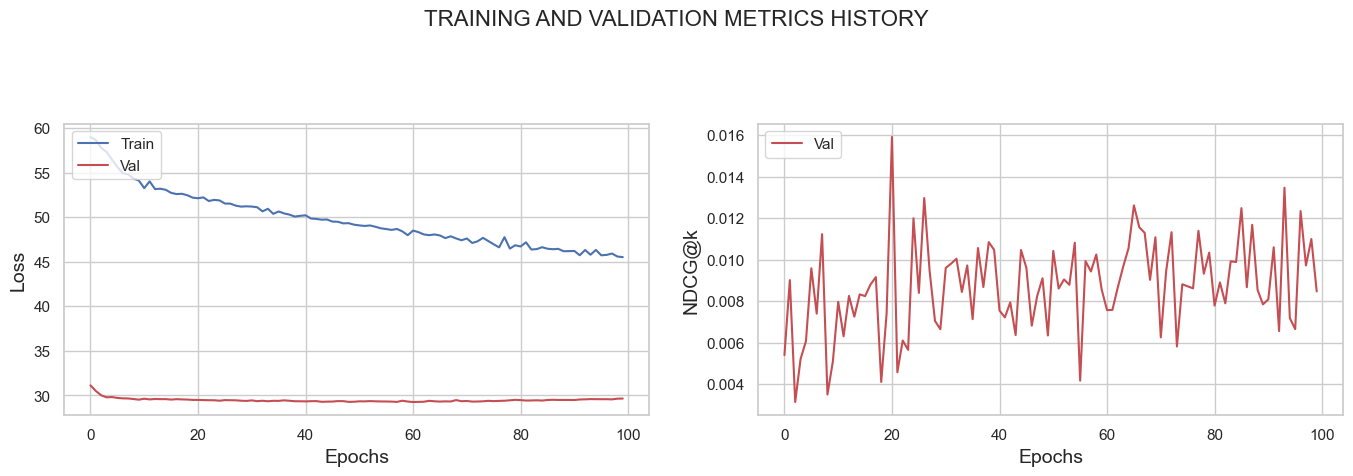

In [24]:
model_without_anneal.display_metrics()

In [25]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

In [26]:
# Model prediction on the training part of test set
top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                k=10,
                                                remove_seen=True
                                                )

# Convert sparse matrix back to df
top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings


# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

58/58 [==============================] - 1s 18ms/step
MAP@10:		0.008153
NDCG@10:	0.011993
Precision@10:	0.002954
Recall@10: 	0.019886


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
